<div style="text-align: center;">

  <div style="background: #023E8A;
              padding: 12px 24px;
              border-radius: 6px;
              display: inline-block;">
    <h1 style="margin: 0; color: #fff;">Stock Sentiment</h1>
  </div>

</div>


Name        | Student Number     
---------------- | --------------
Inês Major         | 20240486       
Luís Semedo          | 20240852  
Pedro Santos | 20240295
Rafael Bernardo | 20240510
Rodrigo Miranda | 20240490

# Imports

In [40]:
# from google.colab import drive
# drive.mount('/content/drive')

In [41]:
!pip install emoji
!pip install -U datasets
!pip install evaluate
!pip install optuna

In [80]:
# ==============================
# Core Libraries
# ==============================
import os
import re
import json
import random
import warnings
from collections import Counter, defaultdict
import string

# ==============================
# Data Manipulation & Visualization
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ==============================
# NLP: NLTK & Preprocessing
# ==============================
import nltk
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download necessary NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt_tab")

import emoji  # emoji handling

# ==============================
# Feature Extraction
# ==============================
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# ==============================
# Model Evaluation & Utilities
# ==============================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)
from sklearn.pipeline import Pipeline

# ==============================
# Machine Learning Models
# ==============================
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

# ==============================
# Deep Learning (TensorFlow / Keras)
# ==============================
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, ReLU, MaxPooling1D,
    GlobalMaxPooling1D, GlobalAveragePooling1D,
    Bidirectional, LSTM, Dropout, Dense,
    BatchNormalization, Activation, concatenate
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# ==============================
# Hugging Face (Transformers & Datasets)
# ==============================
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

# ==============================
# Evaluation & Optimization
# ==============================
import evaluate
import optuna

# ==============================
# Gensim 
# ==============================
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api

# ==============================
# Suppress Warnings
# ==============================
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rbern\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rbern\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rbern\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rbern\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rbern\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Data

In [ ]:
# base_path = "/content/drive/MyDrive/Text Mining/Project"


# train_df = pd.read_csv(f"{base_path}/data/train.csv")
# test_df = pd.read_csv(f"{base_path}/data/test.csv")

#VSCODE
train_df = pd.read_csv(r"../Dados/train.csv")
test_df = pd.read_csv(r"../Dados/test.csv")

train_df.head()


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


# EDA

This notebook presents the Exploratory Data Analysis (EDA) for our Text Mining project, "Stock Sentiment: Predicting market behavior from tweets." The objective of this project is to develop an NLP model capable of classifying market sentiment (Bearish, Bullish, or Neutral) from tweets.
1. **Load and inspect** the training and test datasets (`train.csv` and `test.csv`), confirming their structure and content.  
2. **Summarize main features**, including tweet lengths, missing values, and basic text statistics.  
3. **Visualize sentiment distributions** to understand how many tweets are labeled as Bearish (0), Bullish (1), or Neutral (2).  
4. **Analyze common terms and patterns** through frequency plots and word clouds to identify the most prevalent words in each sentiment class.  
5. **Highlight key insights** and outline next steps for preprocessing and feature engineering.

## Initial Inspection

In [44]:
print("Shape:", train_df.shape)

Shape: (9543, 2)


In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


In [46]:
train_df.describe()

,label
count,9543.000000
mean,1.496280
std,0.743139
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,2.000000


### Missing Values

In [47]:
train_df.isnull().sum()

text     0
label    0
dtype: int64

### Class Distribution

In [48]:
train_df["label"].value_counts()

label
2    6178
1    1923
0    1442
Name: count, dtype: int64

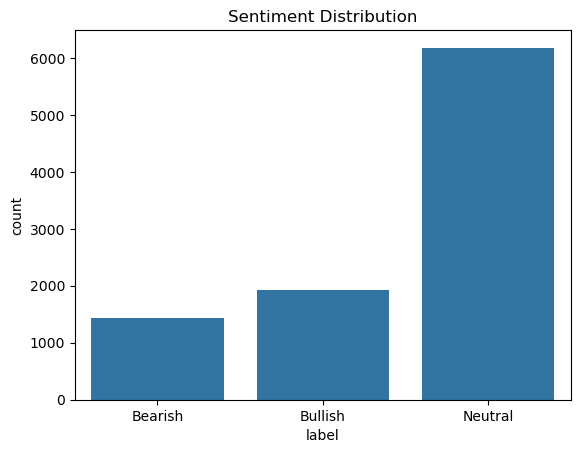

In [49]:
sns.countplot(data=train_df, x='label')
plt.title("Sentiment Distribution")
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.show()

#### Creating clean text without stopwords for this analysis (temporary df)

In [50]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rbern\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
df_no_stopwords = train_df.copy()
df_no_stopwords['text'] = df_no_stopwords['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

Class 0:

In [52]:
df_no_stopwords[df_no_stopwords["label"] == 0]["text"] \
    .str.lower().str.split() \
    .explode() \
    .loc[lambda x: ~x.isin(stopwords)] \
    .value_counts() \
    .head(10)

text
-              210
stock          130
misses          85
u.s.            79
coronavirus     72
oil             67
price           63
market          63
shares          61
china           59
Name: count, dtype: int64

Class 1:

In [53]:
df_no_stopwords[df_no_stopwords["label"] == 1]["text"] \
    .str.lower().str.split() \
    .explode() \
    .loc[lambda x: ~x.isin(stopwords)] \
    .value_counts() \
    .head(10)

text
-          317
stock      231
beats      161
price      132
target     116
shares     110
u.s.       106
revenue    102
new         95
market      92
Name: count, dtype: int64

Class 2:

In [54]:
df_no_stopwords[df_no_stopwords["label"] == 2]["text"] \
    .str.lower().str.split() \
    .explode() \
    .loc[lambda x: ~x.isin(stopwords)] \
    .value_counts() \
    .head(10)

text
-           863
:           343
results     307
#stock      283
new         282
earnings    239
2019        225
dividend    224
reports     222
says        221
Name: count, dtype: int64

Note: We have a lot of -, this likely does not carry much information.

N-Gram Analysis:

In [55]:
trigram_vectorizer = CountVectorizer(ngram_range=(3,3), max_features=30)
X_trigrams = trigram_vectorizer.fit_transform(train_df["text"])
print(trigram_vectorizer.get_feature_names_out())

['19 00pm gmt' 'alpha https co' 'beats on revenue' 'call or presentation'
 'conference call or' 'dividend https co' 'earnings conference call'
 'economy marketscreener https' 'edited transcript of' 'eps beats by'
 'eps misses by' 'hedge funds are' 'marketscreener https co'
 'misses on revenue' 'more https co' 'on revenue https' 'on seeking alpha'
 'price target raised' 'read more and' 'reading https co'
 'reports q3 results' 'results earnings call' 'revenue https co'
 'seeking alpha https' 'sign up for' 'stock https co'
 'stock market update' 'stock marketscreener https' 'stock price target'
 'target raised to']


- Many Trigrams include https; likely not semantically helpful.
- There are several financial phrases that could be strong indicators for certain classes.

### Character Level Patterns: Digits/Punctuation/ Emojis/ URLs

In [56]:
# Count digits
train_df["digit_count"] = train_df["text"].str.count(r"\d")

# Count punctuation
train_df["punct_count"] = train_df["text"].str.count(r"[^\w\s]")

# Count uppercase words
train_df["upper_count"] = train_df["text"].str.findall(r"\b[A-Z]{2,}\b").str.len()

#URL
train_df["has_url"] = train_df["text"].str.contains(r"http\S+", regex=True)
# Mentions
train_df["has_mention"] = train_df["text"].str.contains(r"@\w+", regex=True)
# Hashtags
train_df["has_hashtag"] = train_df["text"].str.contains(r"#\w+", regex=True)

# emojis
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
train_df["emoji_count"] = train_df["text"].apply(lambda x: len(emoji_pattern.findall(x)))

In [57]:
print(train_df["has_url"].value_counts())
print("Percentage of tweets with URLs:", train_df["has_url"].mean() * 100)
print("--------------------------")
print(train_df["has_mention"].value_counts())
print("Percentage of tweets with mentions:", train_df["has_mention"].mean() * 100)
print("--------------------------")
print(train_df["has_hashtag"].value_counts())
print("Percentage of tweets with hashtags:", train_df["has_hashtag"].mean() * 100)
print("--------------------------")

has_url
False    5073
True     4470
Name: count, dtype: int64
Percentage of tweets with URLs: 46.84061615844074
--------------------------
has_mention
False    9249
True      294
Name: count, dtype: int64
Percentage of tweets with mentions: 3.080792203709525
--------------------------
has_hashtag
False    8647
True      896
Name: count, dtype: int64
Percentage of tweets with hashtags: 9.38908100178141
--------------------------


In [58]:
train_df[["digit_count", "punct_count", "upper_count", "emoji_count"]].describe()

,digit_count,punct_count,upper_count,emoji_count
count,9543.000000,9543.000000,9543.000000,9543.000000
mean,2.250655,5.671382,0.724301,0.002829
std,2.605929,4.615066,1.296677,0.055056
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000
50%,2.000000,5.000000,0.000000,0.000000
75%,4.000000,9.000000,1.000000,0.000000
max,35.000000,28.000000,23.000000,2.000000


In [59]:
train_df.groupby("label")[["digit_count", "punct_count", "upper_count", "emoji_count"]].mean()

,digit_count,punct_count,upper_count,emoji_count
label,,,,
0,2.123440,5.269071,0.657420,0.000000
1,2.664067,5.515341,0.798232,0.000520
2,2.151667,5.813856,0.716899,0.004208


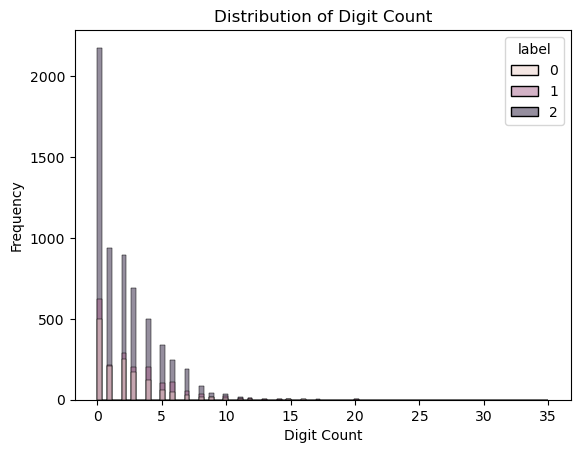

In [60]:
sns.histplot(data=train_df, x="digit_count", hue="label")
plt.title("Distribution of Digit Count")
plt.xlabel("Digit Count")
plt.ylabel("Frequency")
plt.show()

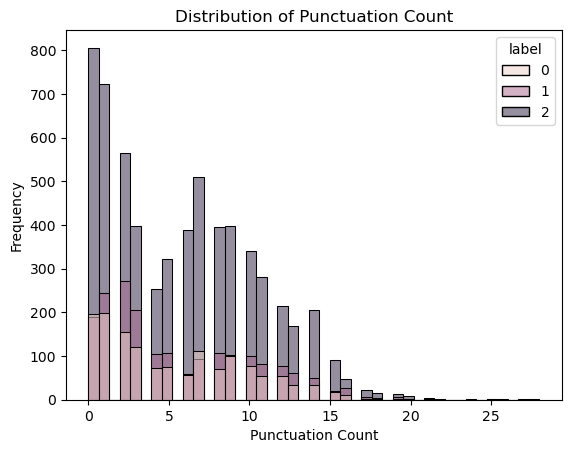

In [61]:
sns.histplot(data=train_df, x="punct_count", hue="label")
plt.title("Distribution of Punctuation Count")
plt.xlabel("Punctuation Count")
plt.ylabel("Frequency")
plt.show()

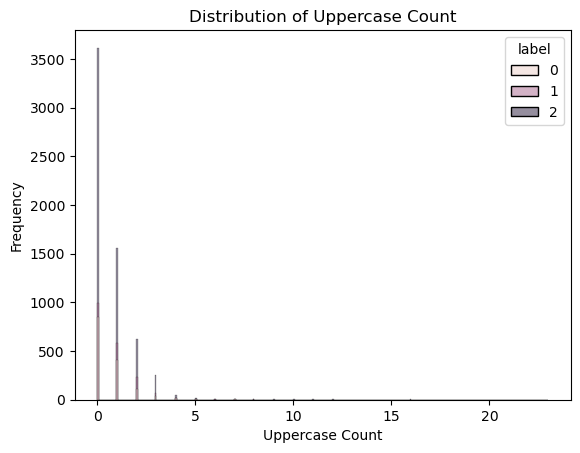

In [62]:
sns.histplot(data=train_df, x="upper_count", hue="label")
plt.title("Distribution of Uppercase Count")
plt.xlabel("Uppercase Count")
plt.ylabel("Frequency")
plt.show()

In [63]:
train_df.groupby("label")[["has_url", "has_mention", "has_hashtag"]].mean()

,has_url,has_mention,has_hashtag
label,,,
0,0.443135,0.020804,0.067961
1,0.391056,0.016121,0.061882
2,0.498381,0.037714,0.109906


- Positive Labels tend to have less URLs/Mentions/ and Hashtags

### Text Analysis

In [64]:
#checking random piece of text from our corpora.
train_df["text"][5]

'$FTI - TechnipFMC downgraded at Berenberg but called Top Pick at Deutsche Bank https://t.co/XKcPDilIuU'

In [65]:
train_df["label"][5]

0

- This particular piece of text chosen at random was classified as 0 -> Bearish.
- Perhaps word "downgraded" had an impact in classifying this piece of text.

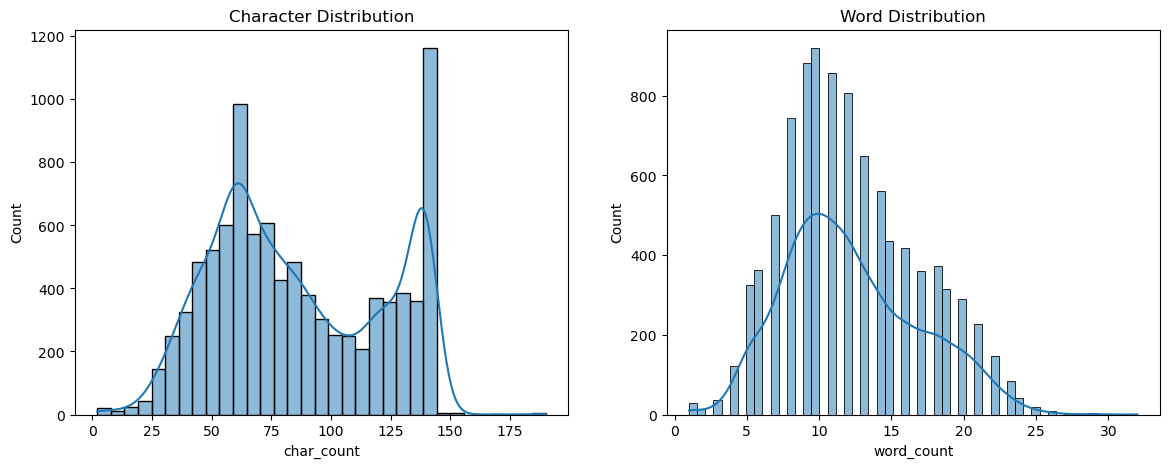

In [66]:
# len in characters
train_df['char_count'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

# histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(train_df['char_count'], kde=True, ax=axs[0]).set_title("Character Distribution")
sns.histplot(train_df['word_count'], kde=True, ax=axs[1]).set_title("Word Distribution")
plt.show()

#### Word Count

In [67]:
train_df['word_count']  = train_df['text'].apply(lambda x: len(str(x).split(" ")))
train_df[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [68]:
train_df["word_count"].describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

- Mean of 12 words per row.
- 31 words was the maximum word count.
- Minimum was 1 word, which we should check if these are relevant for our case.
- Most rows are comprised between 9 and 15 words.

In [69]:
train_df[train_df["word_count"] == 1]

,text,label,digit_count,punct_count,upper_count,has_url,has_mention,has_hashtag,emoji_count,char_count,word_count
1858,SASA聚酯选用英威达PTA技术,2,0,0,0,False,False,False,0,16,1
3943,:),2,0,2,0,False,False,False,0,2,1
3948,@TicToc,2,0,1,0,False,True,False,0,7,1
4360,Damn,2,0,0,0,False,False,False,0,4,1
4440,F5,2,1,0,0,False,False,False,0,2,1
4681,https://t.co/575AH1YRkF,2,4,5,0,True,False,False,0,23,1
4682,https://t.co/9eZPvQhfMq,2,1,5,0,True,False,False,0,23,1
4683,https://t.co/oJxNPEUpWq,2,0,5,0,True,False,False,0,23,1
5505,Wipro赢得Marelli的多年战略性IT协议,2,0,0,0,False,False,False,0,24,1
8290,$TSLA,2,0,1,1,False,False,False,0,5,1


Insights:
- Most rows are simply stock tickers, or a URL or emoji, or non-informative token...
- Removing these rows could be interesting, we could reduce noice, avoid overfitting to rare or meaningless terms.
- We can try to use models where we include these rows, some models might benefit from this other might not. We will iteratively try this and come back to this later.

Yet its important to note that rows that are just tickers, and are labeled as "positive" does not seem right...

In [70]:
train_df[train_df["word_count"] == 2]

,text,label,digit_count,punct_count,upper_count,has_url,has_mention,has_hashtag,emoji_count,char_count,word_count
3090,Brent +4%,1,1,2,0,False,False,False,0,9,2
3945,@MikeCaymanTrades sometimes,2,0,1,0,False,True,False,0,27,2
3980,100% Correct!,2,3,2,0,False,False,False,0,13,2
4914,Next week.,2,0,1,0,False,False,False,0,10,2
5484,Wholesale Trade,2,0,0,0,False,False,False,0,15,2
5512,Woke Sachs,2,0,0,0,False,False,False,0,10,2
5654,$penn coin,2,0,1,0,False,False,False,0,10,2
6511,Housing Starts,2,0,0,0,False,False,False,0,14,2
7276,Kudlow https://t.co/owfUNJQzrb,2,0,5,0,True,False,False,0,30,2
7935,$WW heavy....,1,0,5,1,False,False,False,0,13,2


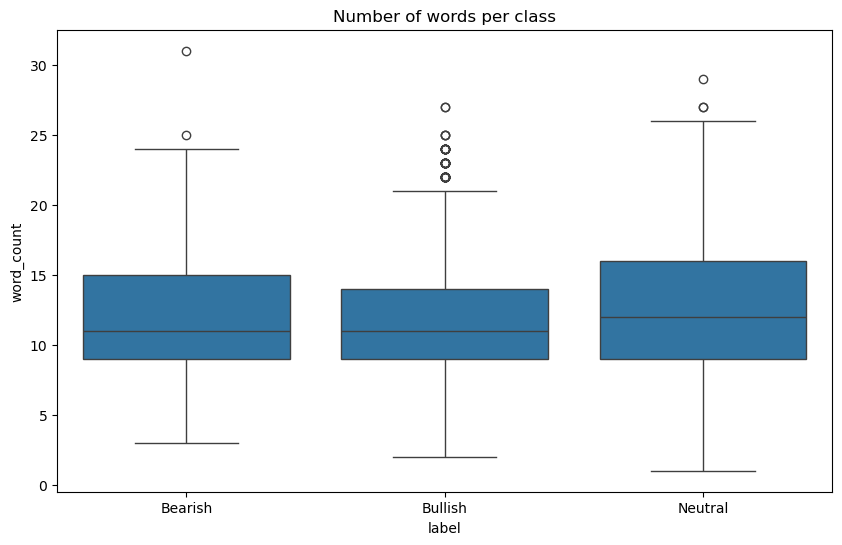

In [71]:
# len by class
plt.figure(figsize=(10,6))
sns.boxplot(x='label', y='word_count', data=train_df)
plt.title("Number of words per class")
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.show()

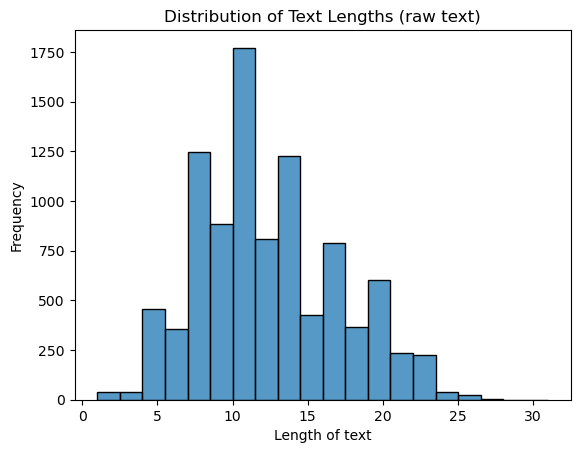

In [72]:
sns.histplot(train_df['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

Individual Words

In [73]:
all_words = ' '.join(train_df['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:15]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
at      539
as      528
is      526
by      414
up      388
Name: count, dtype: int64

- Naturally the most prominent words are stop words... Might be interesting to remove them in preprocessing as they do not carry much semantics.

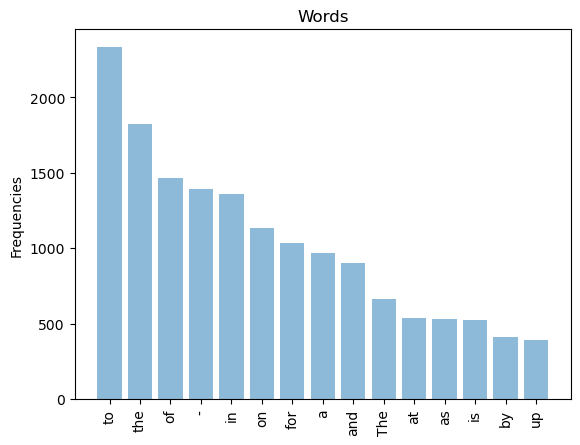

In [74]:
x_labels = freq.index[0:15]
values = freq[:15]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

Rare Words

In [75]:
rare_words = ' '.join(train_df['text']).split()
freq = pd.Series(rare_words).value_counts()
freq.sort_values(ascending=True)[0:25]

alert                      1
Landfill                   1
RNG                        1
Greenleaf                  1
Foods,                     1
SPC,                       1
Carrot                     1
Plant-based                1
Customers                  1
Nationwide                 1
#Grifols                   1
https://t.co/Dnt4oYb4SP    1
founder:                   1
$7.0                       1
‘I                         1
dreaming                   1
consolidation’             1
https://t.co/AB1CLG5Hfa    1
https://t.co/St0OvagWyy    1
Renewables                 1
Greenlane                  1
forward                    1
BMW                        1
Goldrea                    1
Dixie                      1
Name: count, dtype: int64

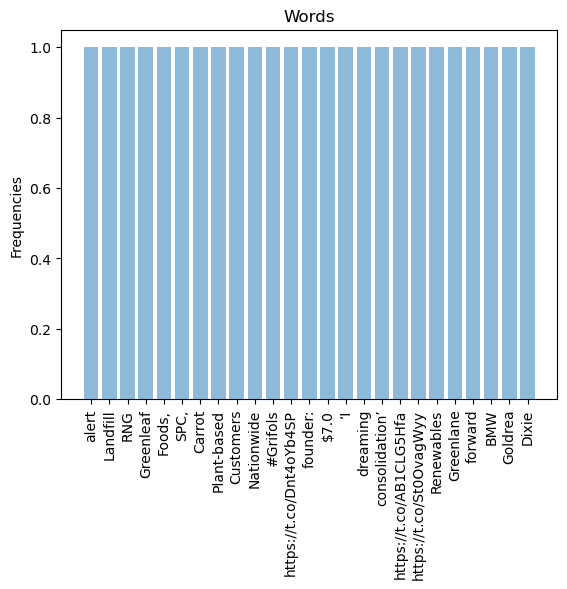

In [35]:
freq = freq.sort_values(ascending=True)
x_labels = freq.index[0:25]
values = freq[:25]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

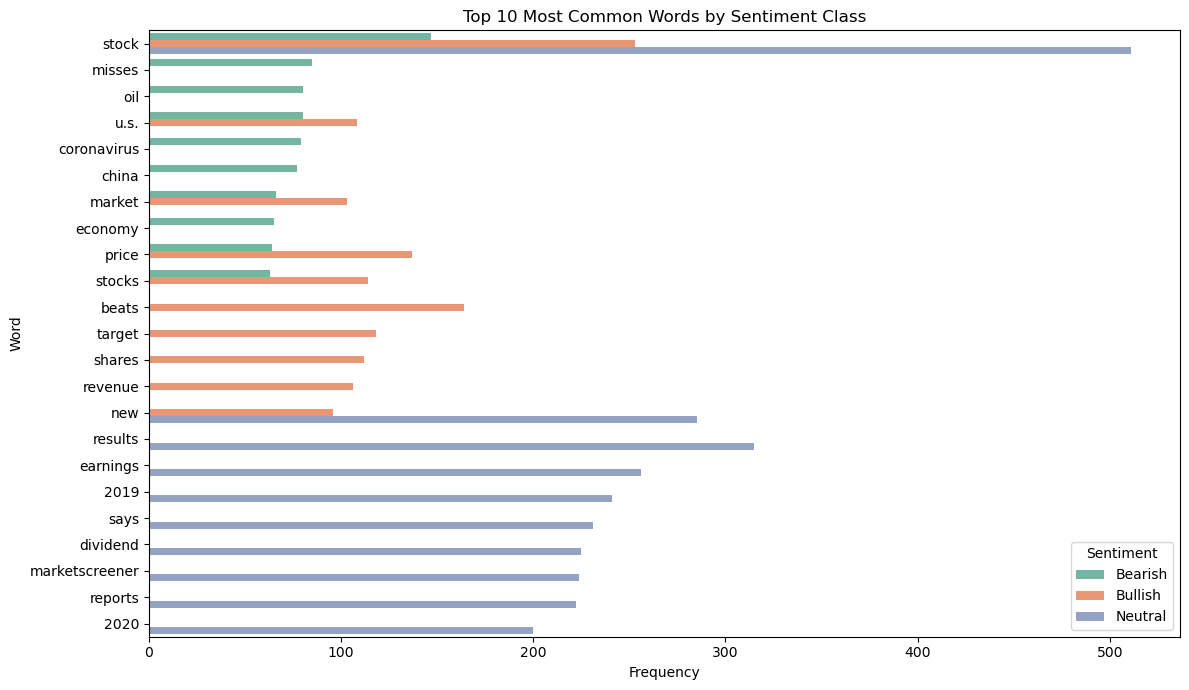

In [79]:

# Custom stopwords
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))
custom_stopwords = english_stopwords.union({
    'https', 't.co', 'co', 'amp', 'rt', 'u', 's',
    '“', '”', '’', "'s", '—', '…'
})

# Tokenization function
def tokenize(text):
    tokens = word_tokenize(str(text).lower())
    return [
        t for t in tokens
        if t not in string.punctuation
        and t not in custom_stopwords
        and not t.startswith('http')
    ]

# Apply tokenization
train_df['tokens'] = train_df['text'].apply(tokenize)

# Map numerical labels to names
label_map = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
train_df['label_name'] = train_df['label'].map(label_map)

# Explode tokens to facilitate frequency counting
exploded = train_df.explode('tokens')

# Group and count token frequencies per class
grouped = (
    exploded.groupby(['label_name', 'tokens'])
    .size()
    .reset_index(name='Frequency')
)

# Get top 10 tokens per class
top_words_df = (
    grouped.groupby('label_name', group_keys=False)
    .apply(lambda x: x.sort_values('Frequency', ascending=False).head(10))
    .rename(columns={'tokens': 'Word', 'label_name': 'Label'})
)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(data=top_words_df, x='Frequency', y='Word', hue='Label', palette='Set2')
plt.title('Top 10 Most Common Words by Sentiment Class')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [82]:
del train_df['label_name']
del train_df['tokens']

## WordClouds

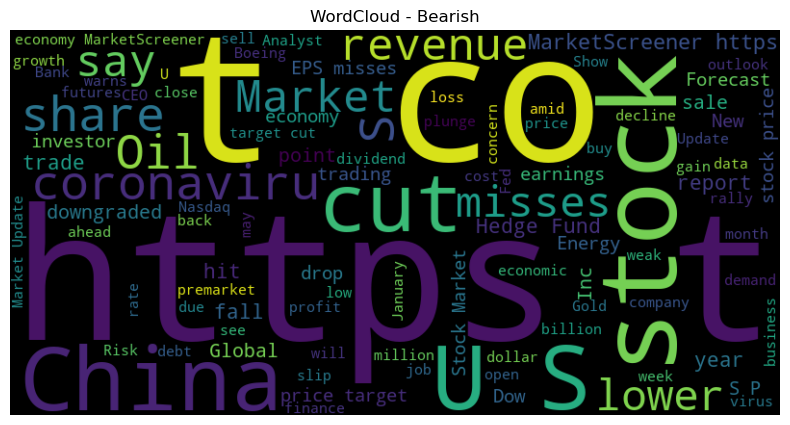

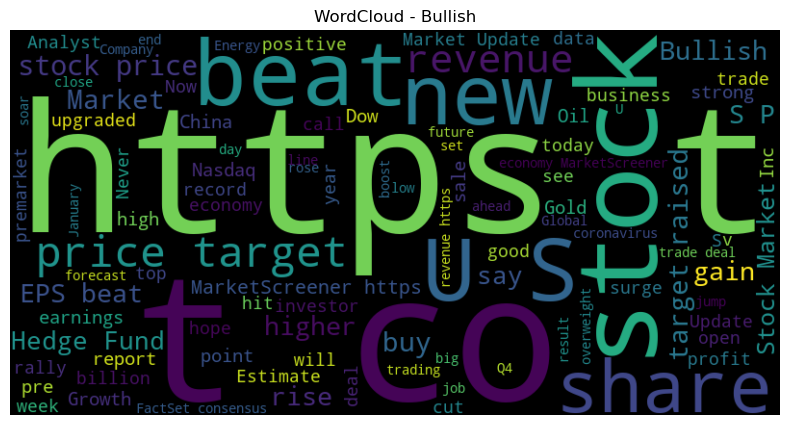

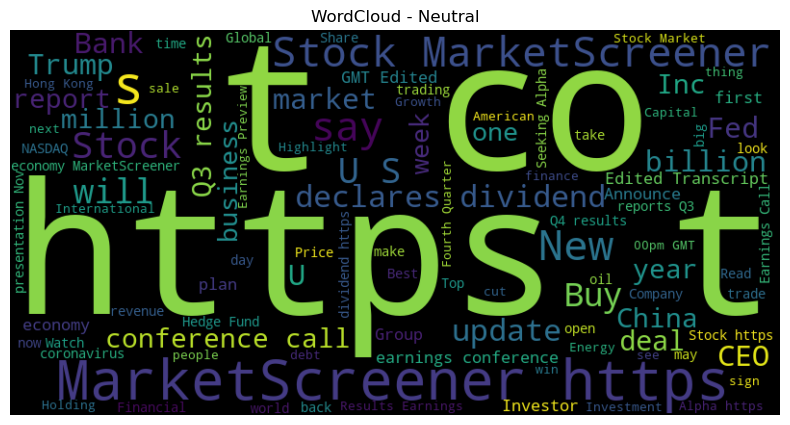

In [84]:
# function for wordcloud by class
def show_wordcloud(data, label_name):
    text = " ".join(data)
    wordcloud = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud - {label_name}")
    plt.show()

for label, name in zip([0,1,2], ['Bearish', 'Bullish', 'Neutral']):
    show_wordcloud(train_df[train_df['label'] == label]['text'], name)

## Noisy Data

In [85]:
# aux functions
train_df['has_url'] = train_df['text'].apply(lambda x: int(bool(re.search(r"http\S+|www\S+", x))))
train_df['has_hashtag'] = train_df['text'].apply(lambda x: int(bool(re.search(r"#\w+", x))))
train_df['has_mention'] = train_df['text'].apply(lambda x: int(bool(re.search(r"@\w+", x))))
train_df['has_noise'] = train_df['text'].apply(lambda x: int(bool(re.search(r"[^\w\s,]", x))))

# percentages
for col in ['has_url', 'has_hashtag', 'has_mention', 'has_noise']:
    print(f"{col}: {train_df[col].mean():.2%}")

# duplicates
print(f"\nTextos duplicados: {train_df.duplicated('text').sum()} ({train_df.duplicated('text').mean():.2%})")

has_url: 46.84%
has_hashtag: 9.39%
has_mention: 3.08%
has_noise: 85.35%

Textos duplicados: 0 (0.00%)


In [86]:
train_df["text"][0]

'$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT'

## Correlations and Key Words

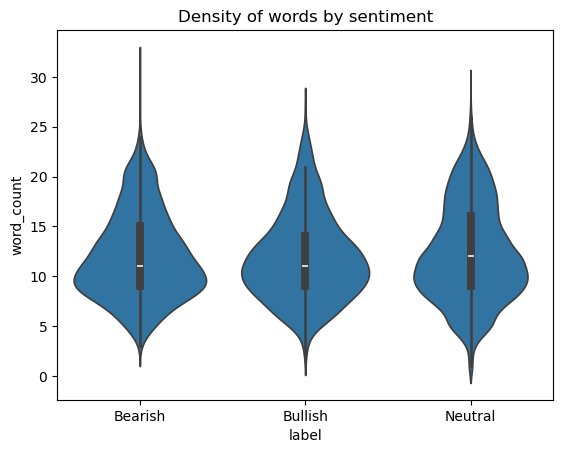

In [87]:
# correlation between n of words and lable
sns.violinplot(x='label', y='word_count', data=train_df)
plt.title("Density of words by sentiment")
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.show()



*Top Words without stop words*

## Important Takeaways

- URLS: Most URLS dont carry meaning. We can indicate that to the model by replacing the URL with something like "URL".

- MENTIONS: Same

- Hashtags: Words in the # might be insightful, yet the # itself is not relevant, same for punctuation.

- Punctuation: ! or ? Could be insightful as it expresses sentiment or doubt or excitment. Yet things like =, -, _ are not as relevant

- Lowercasing : Necessary

# Corpus Split

In [10]:
df_train, df_val = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['label']
)

In [11]:
df_train['label'].value_counts(normalize=True), df_val['label'].value_counts(normalize=True)

(label
 2    0.647367
 1    0.201467
 0    0.151166
 Name: proportion, dtype: float64,
 label
 2    0.647459
 1    0.201676
 0    0.150864
 Name: proportion, dtype: float64)


# Data Preprocessing

In [ ]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def full_preprocess(text):
    # ───  BASIC CLEANING ───
    text = re.sub(r"http\S+|www\S+", "<URL>", text)          # Replace URLs
    text = re.sub(r"@\w+", "<USER>", text)                   # Replace mentions
    text = re.sub(r"#", "", text)                            # Remove hashtag symbol
    text = re.sub(r"[^\w\s]", " ", text)                 # Remove punctuation selectively
    text = text.lower()                                      # Lowercase
    text = re.sub(r"\s+", " ", text).strip()                 # Normalize spaces

    # ───  TOKENIZATION ───
    tokens = nltk.word_tokenize(text)

    # ───  REMOVE STOPWORDS ───
    tokens = [word for word in tokens if word not in stop_words]

    # ───  LEMMATIZATION ───
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # ───  STEMMING ───
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens

In [15]:
X_train_tokens = df_train["text"].apply(full_preprocess)
X_test_tokens = df_val["text"].apply(full_preprocess)

<hr>

# Feature Engineering & Model Evaluation (Classical Models)

## BoW + KNN

In [ ]:
bow = CountVectorizer()

tf_idf = TfidfVectorizer()

# test 1
X_train_bow = bow.fit_transform(X_train_tokens.apply(lambda x: " ".join(x)))
X_test_bow = bow.transform(X_test_tokens.apply(lambda x: " ".join(x)))
# test 2
X_train_tfidf = tf_idf.fit_transform(X_train_tokens.apply(lambda x: " ".join(x)))
X_test_tfidf = tf_idf.transform(X_test_tokens.apply(lambda x: " ".join(x)))

In [21]:
knn_values = [1, 3, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
knn_scores = []
for k in knn_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine", weights="distance")
    knn.fit(X_train_bow, df_train["label"])
    y_pred = knn.predict(X_test_bow)
    report = classification_report(df_val["label"], y_pred, output_dict=True)
    knn_scores.append(report["accuracy"])

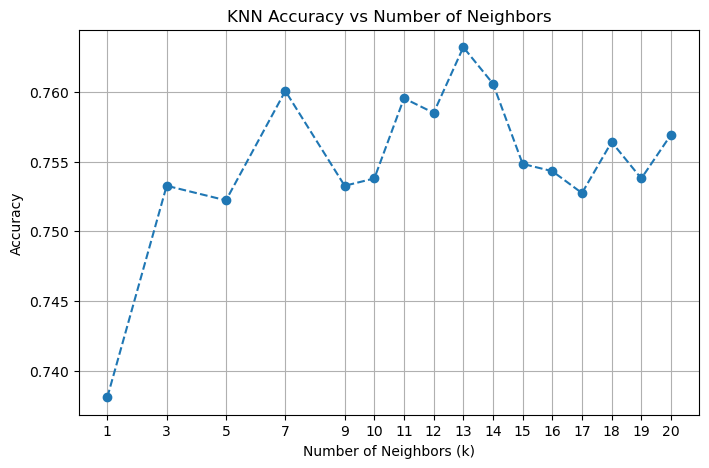

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(knn_values, knn_scores, marker='o', linestyle='--')
plt.title('KNN Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(knn_values)
plt.show()

In [23]:
best_k = 13
best_knn = KNeighborsClassifier(n_neighbors=best_k, metric="cosine", weights="distance")
best_knn.fit(X_train_bow, df_train["label"])
y_best_pred = best_knn.predict(X_test_bow)

labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_best_pred, df_val["label"], target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.30      0.71      0.42       122
     Bullish       0.55      0.69      0.61       305
     Neutral       0.94      0.78      0.85      1482

    accuracy                           0.76      1909
   macro avg       0.60      0.73      0.63      1909
weighted avg       0.84      0.76      0.79      1909



In [ ]:
param_grid_knn = {
    'n_neighbors': [13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    scoring='f1_macro',
    cv=5,
    verbose=1
)

grid.fit(X_train_bow, df_train["label"])

print("Best parameters found: ", grid.best_params_)
print("Best score: ", grid.best_score_)

y_pred_grid = grid.predict(X_test_bow)

print(classification_report(df_val["label"], y_pred_grid, target_names=labels.keys()))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found:  {'metric': 'cosine', 'n_neighbors': 13, 'weights': 'distance'}
Best score:  0.6114179054992614
              precision    recall  f1-score   support

     Bearish       0.71      0.30      0.42       288
     Bullish       0.69      0.55      0.61       385
     Neutral       0.78      0.94      0.85      1236

    accuracy                           0.76      1909
   macro avg       0.73      0.60      0.63      1909
weighted avg       0.75      0.76      0.74      1909



<hr>

## TF-IDF + KNN

In [26]:
knn_values = [1, 3, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
knn_scores = []
for k in knn_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine", weights="distance")
    knn.fit(X_train_tfidf, df_train["label"])
    y_pred = knn.predict(X_test_tfidf)
    report = classification_report(df_val["label"], y_pred, output_dict=True)
    knn_scores.append(report["accuracy"])

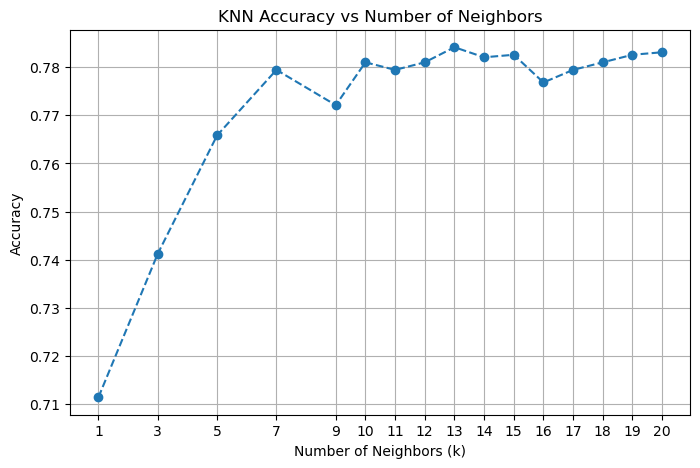

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(knn_values, knn_scores, marker='o', linestyle='--')
plt.title('KNN Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(knn_values)
plt.show()

In [28]:
best_k = 13
best_knn = KNeighborsClassifier(n_neighbors=best_k, metric="cosine", weights="distance")
best_knn.fit(X_train_tfidf, df_train["label"])
y_best_pred = best_knn.predict(X_test_tfidf)

labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_best_pred, df_val["label"], target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.39      0.75      0.51       150
     Bullish       0.55      0.72      0.62       295
     Neutral       0.95      0.80      0.87      1464

    accuracy                           0.78      1909
   macro avg       0.63      0.76      0.67      1909
weighted avg       0.84      0.78      0.80      1909



- **INSIGHTS**: TF-IDF shows most prominent results, for same k VS BoW. No further refinemets will be made as we know that other methods will perform much better.

<hr>

## TF-IDF with SVM

- initial try with GridSearh overfits severly to the train set as it maximizes performance ans memorizes the training set.

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.svm import LinearSVC
# from sklearn.model_selection import GridSearchCV

# svm_pipeline = Pipeline([
#     ("tfidf", TfidfVectorizer()),
#     ("svm", LinearSVC())
# ])

# param_grid = {
#     "tfidf__ngram_range": [(1,1), (1,2), (2,2)],
#     "tfidf__max_df": [0.75, 0.85, 1.0],
#     "tfidf__min_df": [1,2],
#     "tfidf__max_features": [None],
#     "svm__C": [8,9,10,11,12],
#     "svm__class_weight": [None, "balanced"]
# }


# grid = GridSearchCV(
#     svm_pipeline,
#     param_grid=param_grid,
#     scoring="f1_macro",
#     cv=3,
#     verbose=1,
# )


# grid.fit(X_train, y_train)
# # ─── Best Model ───
# print(f"Best Parameters:\n{grid.best_params_}")
# print(f"Best Cross-Validation Accuracy: {grid.best_score_:.4f}")

# y_pred = grid.predict(X_test)
# labels = {"Bearish":0, "Bullish":1, "Neutral":2}
# print(classification_report(y_pred, y_test, target_names = labels.keys()))

Fitting 3 folds for each of 180 candidates, totalling 540 fits


/opt/anaconda3/envs/DL/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/DL/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/DL/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/DL/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/DL/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/DL/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarni

Best Parameters:
{'svm__C': 9, 'svm__class_weight': 'balanced', 'tfidf__max_df': 0.75, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation Accuracy: 0.7189
              precision    recall  f1-score   support

     Bearish       0.59      0.73      0.65       232
     Bullish       0.71      0.76      0.73       360
     Neutral       0.92      0.86      0.89      1317

    accuracy                           0.83      1909
   macro avg       0.74      0.78      0.76      1909
weighted avg       0.84      0.83      0.83      1909



In [ ]:
# # Use the best model from grid search
# best_model = grid.best_estimator_

# # Predict on training data
# y_train_pred = best_model.predict(X_train)

# # Compute metrics
# train_accuracy = accuracy_score(y_train, y_train_pred)
# train_f1_macro = f1_score(y_train, y_train_pred, average="macro")

# print(f"✅ Accuracy on Train Set: {train_accuracy:.4f}")
# print(f"✅ F1 Macro on Train Set: {train_f1_macro:.4f}")
# print("\n📊 Train Set Classification Report:")
# print(classification_report(y_train, y_train_pred, target_names=["Bearish", "Bullish", "Neutral"]))

✅ Accuracy on Train Set: 0.9999
✅ F1 Macro on Train Set: 0.9998

📊 Train Set Classification Report:
              precision    recall  f1-score   support

     Bearish       1.00      1.00      1.00      1154
     Bullish       1.00      1.00      1.00      1538
     Neutral       1.00      1.00      1.00      4942

    accuracy                           1.00      7634
   macro avg       1.00      1.00      1.00      7634
weighted avg       1.00      1.00      1.00      7634



#### Revised Parameters:

In [ ]:
svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,1), max_df=0.75, min_df=5)),
    ("svm", LinearSVC(C=0.1, class_weight="balanced"))
])


svm_pipeline.fit(df_train, df_train["label"])

# ─── Predict ───
y_train_pred = svm_pipeline.predict(df_train)
y_test_pred = svm_pipeline.predict(df_val)

# ─── Train Metrics ───
train_accuracy = accuracy_score(df_train["label"], y_train_pred)
train_f1 = f1_score(df_train["label"], y_train_pred, average="macro")

# ─── Test Metrics ───
test_accuracy = accuracy_score(df_val["label"], y_test_pred)
test_f1 = f1_score(df_val["label"], y_test_pred, average="macro")

# ─── Report ───
print(f"📊 TRAIN SET")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Macro: {train_f1:.4f}")
print(classification_report(df_train["label"], y_train_pred, target_names=["Bearish", "Bullish", "Neutral"]))

print(f"\n📊 TEST SET")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Macro: {test_f1:.4f}")
print(classification_report(df_val["label"], y_test_pred, target_names=["Bearish", "Bullish", "Neutral"]))

📊 TRAIN SET
Accuracy: 0.8601
F1 Macro: 0.8101
              precision    recall  f1-score   support

     Bearish       0.76      0.71      0.74      1154
     Bullish       0.80      0.77      0.78      1538
     Neutral       0.90      0.92      0.91      4942

    accuracy                           0.86      7634
   macro avg       0.82      0.80      0.81      7634
weighted avg       0.86      0.86      0.86      7634


📊 TEST SET
Accuracy: 0.8036
F1 Macro: 0.7226
              precision    recall  f1-score   support

     Bearish       0.66      0.56      0.60       288
     Bullish       0.73      0.65      0.69       385
     Neutral       0.85      0.91      0.88      1236

    accuracy                           0.80      1909
   macro avg       0.75      0.70      0.72      1909
weighted avg       0.80      0.80      0.80      1909



<hr>
<hr>

## Word2Vec + CNN + BiLSTM

In [34]:
word2vec = Word2Vec(
    sentences = X_train_tokens,
    vector_size = 200,
    window = 3,
    min_count=1,
    workers = 8,
    sg=1,
    epochs=15,
    seed=42,
    negative=5
)

In [35]:
X_train_vec = X_train_tokens.apply(lambda x: [word2vec.wv[word] for word in x if word in word2vec.wv])
X_test_vec = X_test_tokens.apply(lambda x: [word2vec.wv[word] for word in x if word in word2vec.wv])

In [36]:
tweet_lengths = X_train_vec.apply(len)
tweet_lengths.describe()
maxlen = int(tweet_lengths.quantile(0.95))  # covers 95% of tweets
print(maxlen)

15


In [37]:
# Set maxlen same as before or based on training data
maxlen = 15
embedding_dim = 200

def pad_tweet_vector(tweet_vec, maxlen, dim):
    if len(tweet_vec) >= maxlen:
        return tweet_vec[:maxlen]
    else:
        return tweet_vec + [np.zeros(dim)] * (maxlen - len(tweet_vec))

X_train_pad = np.array([pad_tweet_vector(v, maxlen, embedding_dim) for v in X_train_vec])
X_test_pad = np.array([pad_tweet_vector(v, maxlen, embedding_dim) for v in X_test_vec])

In [38]:
input_layer = Input(shape=(maxlen, embedding_dim))


# ─── CNN Block ───
conv1 = Conv1D(128, 2, padding='valid', activation='relu')(input_layer)
conv1 = BatchNormalization()(conv1)
conv2 = Conv1D(256, 2, padding='valid', activation='relu')(conv1)
conv2 = GlobalMaxPooling1D()(conv2)

# ─── BiLSTM Block ───
bilstm1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15))(input_layer)
bilstm2 = Bidirectional(LSTM(64, return_sequences=False, dropout=0.15))(bilstm1)

# ─── Merge CNN + LSTM ───
merged = concatenate([conv2, bilstm2])
drop = Dropout(0.45)(merged)

output_layer = Dense(3, activation='softmax')(drop)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-5),
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 15, 200)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 14, 128)   │     51,328 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 14, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 13, 256)   │     65,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 15, 256)   │    336,896 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │      1,155 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 620,035 (2.37 MB)

 Trainable params: 619,779 (2.36 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
history = model.fit(
    X_train_pad, df_train["label"],
    validation_data=(X_test_pad, df_val["label"]),
    epochs=45,
    batch_size=32
)

Epoch 1/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.3469 - loss: 2.0563 - val_accuracy: 0.6475 - val_loss: 0.9137
Epoch 2/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.5375 - loss: 1.4548 - val_accuracy: 0.6595 - val_loss: 0.8411
Epoch 3/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.5597 - loss: 1.3706 - val_accuracy: 0.6710 - val_loss: 0.8477
Epoch 4/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.5775 - loss: 1.2793 - val_accuracy: 0.6799 - val_loss: 0.8444
Epoch 5/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.5844 - loss: 1.2192 - val_accuracy: 0.6826 - val_loss: 0.8292
Epoch 6/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.6167 - loss: 1.1168 - val_accuracy: 0.6909 - val_loss: 0.8005
Epoch 7/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.6174 - loss: 1.0993 - val_accuracy: 0.6936 - val_loss: 0.7870
Epoch 8/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.6188 - loss: 1.0878 - 

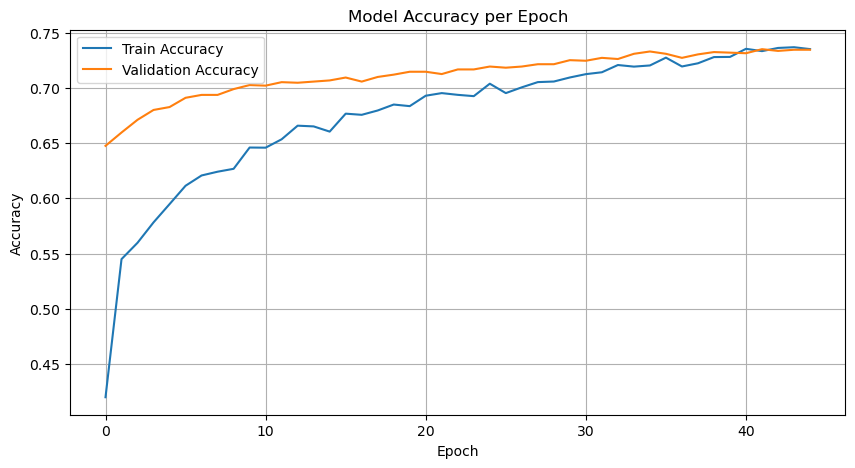

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

<hr>

## GloVe + CNN + BiLSTM

- Following Architecture leverages:
    - GloVe: Pretrained word embeddings;
    - CNN : For extracting local features like n-gram patterns
    - BiLSTM: For capturing sequential dependencies
    - Dense: For Final Classification

Sources: https://doi.org/10.1155/2022/7212366

- Although word2vec has good lexical analogy performance, it is limited by the characteristics of local windows and is hard to use the global lexical cooccurrence statistics effectively. GloVe combines the advantages of the above two, combines the global statistical information with the local context window, and has a better effect of word vectorization.

In [39]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def full_preprocess_glove(text):
    # ─── STEP 1: BASIC CLEANING ───
    text = re.sub(r"http\S+|www\S+", "<URL>", text)          # Replace URLs
    text = re.sub(r"@\w+", "<USER>", text)                   # Replace mentions
    text = re.sub(r"#", "", text)                            # Remove hashtag symbol
    text = re.sub(r"[^\w\s]", " ", text)                     # Remove punctuation
    text = text.lower()                                      # Lowercase
    text = re.sub(r"\s+", " ", text).strip()                 # Normalize spaces

    # ─── STEP 2: TOKENIZATION ───
    tokens = nltk.word_tokenize(text)

    # ─── STEP 3: REMOVE STOPWORDS ───
    tokens = [word for word in tokens if word not in stop_words]

    # ─── STEP 4: LEMMATIZATION ───
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

In [42]:
X_train_glove = df_train["text"].apply(full_preprocess_glove)
X_test_glove = df_val["text"].apply(full_preprocess_glove)

In [ ]:
# Already did in Word2Vec + CNN + BiLSTM
print(maxlen)

15


In [44]:
X_train_text = X_train_glove.apply(lambda tokens: ' '.join(tokens))
X_test_text = X_test_glove.apply(lambda tokens: ' '.join(tokens))

# Create and fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_text)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # +1 for padding token

#### Downloading GloVe Embeddings

In [ ]:
glove_path = r"/Users/pedrosantos/Documents 2/Text Mining/text_mining_2025/Pedro/glove.6B.300d.txt"

def load_glove_embeddings(glove_path, word_index, embedding_dim=300):
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
 
    for word, i in word_index.items():
        vector = embeddings_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

    return embedding_matrix

In [ ]:
embedding_dim = 300

embedding_matrix = load_glove_embeddings(glove_path, word_index, embedding_dim)

input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True)(input_layer)

In [ ]:
# ─── CNN Block ──────────────────────────────────────────────
conv1 = Conv1D(filters=128, kernel_size=2, activation='relu', padding="valid")(embedding_layer)
conv1 = BatchNormalization()(conv1)

conv2 = Conv1D(filters=256, kernel_size=2, activation='relu', padding="valid")(conv1)
conv2 = BatchNormalization()(conv2)

cnn_pool = GlobalMaxPooling1D()(conv2)

# ─── BiLSTM Block ───────────────────────────────────────────
bilstm1 = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
bilstm2 = Bidirectional(LSTM(64, return_sequences=False))(bilstm1)

# ─── Concatenate CNN + BiLSTM ───────────────────────────────
merged = Concatenate()([cnn_pool, bilstm2])

# ─── Output Block ───────────────────────────────────────────
dropout = Dropout(0.6)(merged)
output_layer = Dense(3, activation='softmax')(dropout)

# ─── Build Model ────────────────────────────────────────────
model = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 15, 300)   │  3,770,100 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 14, 128)   │     76,928 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 128)   │        512 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 13, 256)   │     65,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 256)   │      1,024 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 15, 256)   │    439,296 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 128)       │    164,352 │ bidirectional_7[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 384)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │      1,155 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,519,159 (17.24 MB)

 Trainable params: 4,518,391 (17.24 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
history = model.fit(X_train_pad, df_train["label"],
                    epochs=45,
                    batch_size=32,
                    validation_data=(X_test_pad, df_val["label"]))


Epoch 1/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.3533 - loss: 3.3474 - val_accuracy: 0.5416 - val_loss: 1.0255
Epoch 2/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.4428 - loss: 2.5929 - val_accuracy: 0.6035 - val_loss: 1.1789
Epoch 3/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.4794 - loss: 2.4267 - val_accuracy: 0.6239 - val_loss: 1.2191
Epoch 4/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.5126 - loss: 2.2746 - val_accuracy: 0.6380 - val_loss: 1.1995
Epoch 5/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.5325 - loss: 2.1960 - val_accuracy: 0.6511 - val_loss: 1.1497
Epoch 6/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.5257 - loss: 2.1379 - val_accuracy: 0.6642 - val_loss: 1.1263
Epoch 7/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.5648 - loss: 2.0038 - val_accuracy: 0.6731 - val_loss: 1.0772
Epoch 8/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.5603 - loss: 1.9562 - 

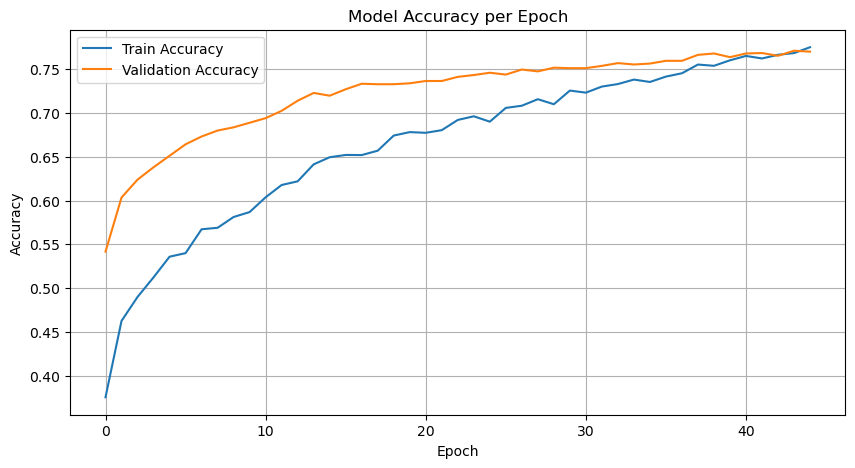

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

<hr>
<hr>
<hr>

## Encoders

In [ ]:
def prepare_for_bert(text):
    text = html.unescape(text)
    text = re.sub(r"http\S+|www\S+", "[URL]", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

def detect_signals(text):
    return {
        'has_url': int(bool(re.search(r"http\S+|www\S+", text))),
        'has_hashtag': int(bool(re.search(r"#\w+", text))),
        'has_mention': int(bool(re.search(r"@\w+", text))),
        'has_cashtag': int(bool(re.search(r"\$\w+", text))),
        'has_emoji': int(emoji.emoji_count(text) > 0)
    }

def enrich_text(row):
    text = row['bert_text']
    tags = []
    if row['has_emoji']:
        tags.append("This tweet contains emojis.")
    if row['has_url']:
        tags.append("This tweet contains a URL.")
    if row['has_cashtag']:
        tags.append("This tweet contains a cashtag.")
    if row['has_hashtag']:
        tags.append("This tweet contains a hashtag.")
    tags.append(f"This tweet has {len(text.split())} words.")
    enriched_intro = " ".join(tags)
    return enriched_intro + " " + text

In [ ]:
def preprocess_dataframe(df):
    df = df.copy()
    df['bert_text'] = df['text'].apply(prepare_for_bert)
    signal_cols = df['text'].apply(detect_signals).apply(pd.Series)
    df = pd.concat([df, signal_cols], axis=1)
    df['bert_text_enriched'] = df.apply(enrich_text, axis=1)
    return df

In [ ]:
df_proc = preprocess_dataframe(train_df)


# Feature Engineering Transformer-Based Encoders

## Encoders

In [ ]:
def prepare_hf_datasets(df, tokenizer):
    df_train, df_val = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

    train_data = Dataset.from_pandas(df_train[['bert_text_enriched', 'label']].rename(columns={'bert_text_enriched': 'text'}))
    val_data = Dataset.from_pandas(df_val[['bert_text_enriched', 'label']].rename(columns={'bert_text_enriched': 'text'}))

    def tokenize_function(example):
        return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

    train_tokenized = train_data.map(tokenize_function, batched=True)
    val_tokenized = val_data.map(tokenize_function, batched=True)

    train_tokenized.set_format("torch")
    val_tokenized.set_format("torch")

    return train_tokenized, val_tokenized


# Classification Models Transformer-Based Encoders

## Encoders

In [9]:
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.asarray(np.argmax(logits, axis=-1))
    labels = np.asarray(labels)

    return {
        "eval_accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "eval_precision_macro": precision_metric.compute(predictions=predictions, references=labels, average="macro")["precision"],
        "eval_recall_macro": recall_metric.compute(predictions=predictions, references=labels, average="macro")["recall"],
        "eval_f1_macro": f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"],
        "eval_precision_weighted": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "eval_recall_weighted": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "eval_f1_weighted": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"],
    }

In [ ]:
def train_encoder_model(df, model_checkpoint):
    tokenizer = AutoTokenizer.from_pretrained(
        model_checkpoint,
        use_fast=False if "bertweet" in model_checkpoint else True
    )

    train_tokenized, val_tokenized = prepare_hf_datasets(df, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

    training_args = TrainingArguments(
        output_dir="./results_roberta",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
        logging_dir="./logs_roberta",
        logging_steps=50,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()
    return trainer

### RoBERTa-Base

In [ ]:
trainer_roberta_base = train_encoder_model(df_proc, model_checkpoint="roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.412300,0.356883,0.863803,0.819294,0.864489,0.836951,0.874216,0.863803,0.866259
2,0.302600,0.325923,0.869041,0.818654,0.877016,0.842041,0.882722,0.869041,0.872238
3,0.195700,0.359168,0.887376,0.845373,0.885619,0.863566,0.893530,0.887376,0.888966
4,0.140000,0.390623,0.891042,0.849370,0.888926,0.866369,0.897402,0.891042,0.892630
5,0.091700,0.454346,0.895233,0.855334,0.885491,0.869121,0.899320,0.895233,0.896487
6,0.083400,0.494401,0.893138,0.849966,0.893037,0.869308,0.899471,0.893138,0.894764
7,0.047500,0.561770,0.905186,0.886130,0.873127,0.879450,0.904568,0.905186,0.904761
8,0.037100,0.580321,0.906757,0.874894,0.892046,0.883142,0.908341,0.906757,0.907331
9,0.030900,0.635811,0.898900,0.861982,0.889789,0.875029,0.902095,0.898900,0.899855
10,0.003800,0.617978,0.905186,0.873478,0.889753,0.881330,0.906663,0.905186,0.905728


### RoBERTa-large

In [ ]:
trainer_roberta_large = train_encoder_model(df_proc, model_checkpoint="roberta-large")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.394800,0.326736,0.874280,0.849292,0.836098,0.841710,0.874826,0.874280,0.873922
2,0.279400,0.278501,0.893662,0.856487,0.884961,0.868862,0.898325,0.893662,0.894991
3,0.190300,0.321190,0.899424,0.874728,0.873050,0.872252,0.901408,0.899424,0.899528
4,0.108100,0.364620,0.908329,0.897886,0.870002,0.883165,0.907920,0.908329,0.907555
5,0.071100,0.486302,0.903614,0.881838,0.875538,0.877925,0.904377,0.903614,0.903548
6,0.069700,0.586524,0.897328,0.860809,0.887788,0.873497,0.900339,0.897328,0.898261
7,0.029400,0.621929,0.898900,0.869913,0.880303,0.874976,0.899716,0.898900,0.899207


### DeBERTa-v3-base

In [13]:
trainer_deberta_base = train_encoder_model(df_proc, model_checkpoint="microsoft/deberta-v3-base")


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.473400,0.390318,0.861184,0.825209,0.842607,0.827866,0.870433,0.861184,0.862755
2,0.311000,0.312158,0.884756,0.838813,0.886363,0.859896,0.892586,0.884756,0.886659
3,0.213900,0.381138,0.881613,0.840251,0.883450,0.856468,0.892158,0.881613,0.883989
4,0.136000,0.352529,0.899948,0.871505,0.878419,0.874424,0.901320,0.899948,0.900367
5,0.106200,0.447289,0.898376,0.872040,0.869912,0.870947,0.898285,0.898376,0.898312
6,0.072800,0.476285,0.895757,0.856880,0.884886,0.869872,0.899311,0.895757,0.896890
7,0.056900,0.520211,0.892090,0.853348,0.884748,0.866910,0.897488,0.892090,0.893618


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

### DeBERTa-v3-large

In [ ]:
trainer_deberta_large = train_encoder_model(df_proc, model_checkpoint="microsoft/deberta-v3-large")


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.458900,0.369369,0.880566,0.842038,0.863063,0.850719,0.884895,0.880566,0.881801
2,0.261100,0.318410,0.885804,0.837906,0.896719,0.863007,0.896969,0.885804,0.888002
3,0.200900,0.338856,0.905186,0.883298,0.873392,0.877779,0.905465,0.905186,0.904963
4,0.084300,0.446625,0.906234,0.880129,0.880502,0.880277,0.906395,0.906234,0.906294
5,0.088800,0.486326,0.908853,0.888823,0.875941,0.882078,0.908222,0.908853,0.908378
6,0.038900,0.512658,0.905186,0.877794,0.879075,0.878426,0.905275,0.905186,0.905225
7,0.031800,0.514481,0.909377,0.883779,0.880636,0.882147,0.909355,0.909377,0.909327
8,0.018800,0.536119,0.906757,0.874466,0.886733,0.880427,0.907818,0.906757,0.907156
9,0.027300,0.572112,0.910948,0.887676,0.881789,0.884485,0.910576,0.910948,0.910641
10,0.014100,0.587574,0.907805,0.877400,0.886676,0.881929,0.908542,0.907805,0.908089


### BERTweet

In [ ]:
trainer_bertweet = train_encoder_model(df_proc, model_checkpoint="vinai/bertweet-base")


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.451000,0.417592,0.839707,0.792301,0.816142,0.798917,0.850249,0.839707,0.842286
2,0.354700,0.340081,0.868518,0.822607,0.852181,0.836311,0.873209,0.868518,0.870038
3,0.258700,0.369093,0.877947,0.834605,0.859939,0.844545,0.884762,0.877947,0.879950
4,0.171600,0.394826,0.883709,0.847353,0.854599,0.850060,0.885649,0.883709,0.884220
5,0.123800,0.459708,0.879518,0.836325,0.864338,0.849147,0.883734,0.879518,0.880905
6,0.085100,0.504903,0.881090,0.843887,0.851779,0.846905,0.883367,0.881090,0.881765
7,0.048700,0.528946,0.888947,0.859387,0.853745,0.855863,0.889588,0.888947,0.888857
8,0.062500,0.561879,0.883185,0.844117,0.860277,0.851348,0.885824,0.883185,0.884071
9,0.040500,0.581188,0.881613,0.840970,0.858289,0.848895,0.884287,0.881613,0.882561
10,0.031600,0.573901,0.886328,0.849430,0.861008,0.854746,0.887944,0.886328,0.886898


### MPNet-base

In [ ]:
trainer_mpnetbase = train_encoder_model(df_proc, model_checkpoint="microsoft/mpnet-base")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/472k [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.471500,0.391451,0.872184,0.837018,0.846877,0.841398,0.873544,0.872184,0.872593
2,0.341500,0.305969,0.889995,0.847801,0.887855,0.865962,0.895669,0.889995,0.891503
3,0.267200,0.318901,0.893662,0.867176,0.856781,0.861794,0.893029,0.893662,0.893208
4,0.178100,0.322918,0.895233,0.856809,0.884895,0.869741,0.898809,0.895233,0.896346
5,0.163300,0.383830,0.895233,0.868855,0.874916,0.869255,0.899594,0.895233,0.895847
6,0.102600,0.388041,0.893138,0.853158,0.885935,0.868306,0.897461,0.893138,0.894353
7,0.088200,0.432051,0.896281,0.859749,0.878624,0.868625,0.898587,0.896281,0.897109


### ALBERT-base-v2

In [ ]:
trainer_albert_base = train_encoder_model(df_proc, model_checkpoint="albert-base-v2")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.473100,0.431277,0.818753,0.765948,0.782857,0.773092,0.823134,0.818753,0.820272
2,0.340500,0.369885,0.861184,0.824195,0.823395,0.823753,0.860922,0.861184,0.861028
3,0.224900,0.386045,0.867470,0.828408,0.829599,0.828534,0.867846,0.867470,0.867409
4,0.143000,0.509521,0.867470,0.840883,0.821519,0.827805,0.869031,0.867470,0.866163
5,0.074500,0.617779,0.866946,0.829698,0.829076,0.829352,0.866885,0.866946,0.866896
6,0.054500,0.670779,0.875851,0.840912,0.844935,0.842893,0.876235,0.875851,0.876027
7,0.030900,0.756506,0.868518,0.848507,0.814982,0.829003,0.868908,0.868518,0.866798
8,0.013300,0.794083,0.870089,0.835342,0.828906,0.831928,0.869631,0.870089,0.869729
9,0.005800,0.834618,0.865898,0.835401,0.817262,0.825952,0.864408,0.865898,0.864874


### Ensemble

#### RoBERTa-large + DeBERTa-v3-large

In [ ]:
def find_best_ensemble_weight(probas_a, probas_b, y_true, step=0.01):
    best_f1 = 0
    best_w = 0
    for w in np.arange(0, 1 + step, step):
        ensemble = w * probas_a + (1 - w) * probas_b
        preds = np.argmax(ensemble, axis=1)
        f1 = f1_score(y_true, preds, average="macro")
        if f1 > best_f1:
            best_f1 = f1
            best_w = w
    return best_w, best_f1



In [ ]:
probas_deberta = trainer_deberta_large.predict(trainer_deberta_large.eval_dataset).predictions
probas_roberta = trainer_roberta_large.predict(trainer_roberta_large.eval_dataset).predictions
y_true = trainer_deberta_large.predict(trainer_deberta_large.eval_dataset).label_ids

best_w, best_f1 = find_best_ensemble_weight(probas_deberta, probas_roberta, y_true)

ensemble_probas = best_w * probas_deberta + (1 - best_w) * probas_roberta
ensemble_preds = np.argmax(ensemble_probas, axis=1)

print(f"\nBest ensemble weight: {best_w:.2f} (DeBERTa), {1-best_w:.2f} (RoBERTa)")
print(f"Macro F1-score: {best_f1:.4f}")
print("\nFull Classification Report:")
print(classification_report(y_true, ensemble_preds, target_names=['Bearish', 'Bullish', 'Neutral']))



Best ensemble weight: 0.37 (DeBERTa), 0.63 (RoBERTa)
Macro F1-score: 0.8927

Full Classification Report:
              precision    recall  f1-score   support

     Bearish       0.86      0.81      0.84       288
     Bullish       0.92      0.88      0.90       385
     Neutral       0.93      0.95      0.94      1236

    accuracy                           0.92      1909
   macro avg       0.90      0.88      0.89      1909
weighted avg       0.92      0.92      0.92      1909



### Grid Search Roberta-Large

In [ ]:
# save_path = "/content/drive/MyDrive/Text Mining/Project"
# optuna_db = f"sqlite:///{save_path}/optuna_study.db"
# study_name = "roberta_large_tuning"

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("roberta-large", use_fast=True)
# train_tokenized, val_tokenized = prepare_hf_datasets(df_proc, tokenizer)

# def model_init():
#     return AutoModelForSequenceClassification.from_pretrained("roberta-large", num_labels=3)


# def hp_space(trial):
#     return {
#         "learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
#         "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
#         "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
#     }

# accuracy_metric = evaluate.load("accuracy")
# precision_metric = evaluate.load("precision")
# recall_metric = evaluate.load("recall")
# f1_metric = evaluate.load("f1")

# def compute_metrics_roberta(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)

#     return {
#         "eval_accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
#         "eval_precision_macro": precision_metric.compute(predictions=predictions, references=labels, average="macro")["precision"],
#         "eval_recall_macro": recall_metric.compute(predictions=predictions, references=labels, average="macro")["recall"],
#         "eval_f1_macro": f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"],
#         "eval_precision_weighted": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
#         "eval_recall_weighted": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
#         "eval_f1_weighted": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"],
#     }

# training_args = TrainingArguments(
#     output_dir="./optuna_results",
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     num_train_epochs=10,
#     fp16=True,
#     save_total_limit=1,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_f1_macro",
#     greater_is_better=True,
#     logging_dir="./logs",
#     logging_steps=50,
#     report_to="none"
# )

# trainer = Trainer(
#     model_init=model_init,
#     args=training_args,
#     train_dataset=train_tokenized,
#     eval_dataset=val_tokenized,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics_roberta,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
# )

# def compute_objective(metrics):
#     return metrics["eval_f1_macro"]

# best_trial = trainer.hyperparameter_search(
#     direction="maximize",
#     hp_space=hp_space,
#     compute_objective=compute_objective,
#     backend="optuna",
#     n_trials=200,
#     study_name=study_name,
#     storage=optuna_db,
#     load_if_exists=True
# )

# with open(f"{save_path}/best_hyperparameters.json", "w") as f:
#     json.dump(best_trial.hyperparameters, f, indent=4)

# study = optuna.load_study(study_name=study_name, storage=optuna_db)
# df_trials = study.trials_dataframe()
# df_trials = df_trials.rename(columns={"value": "f1_macro"})
# df_trials.to_csv(f"{save_path}/optuna_trials.csv", index=False)


Instead of a traditional grid search, we used Optuna to optimize the hyperparameters. One of its main advantages is that it allows us to resume the search exactly where it stopped in case the runtime is interrupted (e.g., GPU crashes, Colab disconnects, or kernel restarts).

The optuna_study.db file stores the full history of the optimization in a persistent SQLite database on Google Drive.

By setting load_if_exists=True, Optuna checks how many trials were already completed and continues the search only for the remaining ones without repeating anything. This allows us to build the final tuning progressively, in multiple sessions if needed, while keeping the process reproducible and efficient.

In [ ]:
study = optuna.load_study(
    study_name="roberta_large_tuning",
    storage="sqlite:////content/drive/MyDrive/Text Mining/Project/optuna_study.db"
)

print(f"Concluded trials: {len(study.trials)}")


Concluded trials: 83


cell below if we want to do runs from where it stopped (advantage of optuna)

In [ ]:
# best_trial = trainer.hyperparameter_search(
#     direction="maximize",
#     hp_space=hp_space,
#     compute_objective=compute_objective,
#     backend="optuna",
#     n_trials=200,
#     study_name=study_name,
#     storage=optuna_db,
#     load_if_exists=True
# )


#### Showing top-10 results

In [ ]:
save_path = "/content/drive/MyDrive/Text Mining/Project"
optuna_db = f"sqlite:///{save_path}/optuna_study.db"
study_name_roberta = "roberta_large_tuning"

study_roberta = optuna.load_study(study_name=study_name_roberta, storage=optuna_db)

df_trials_2 = study_roberta.trials_dataframe()
df_trials_2 = df_trials_2.rename(columns={"value": "f1_macro"})
df_trials_2_sorted = df_trials_2.sort_values(by="f1_macro", ascending=False).reset_index(drop=True)
df_trials_2_sorted.head(10)


,number,f1_macro,datetime_start,datetime_complete,duration,params_learning_rate,params_per_device_train_batch_size,params_weight_decay,state
0,12,0.892314,2025-06-09 07:39:36.562397,2025-06-09 07:51:39.170729,0 days 00:12:02.608332,0.000004,8,0.132473,COMPLETE
1,4,0.892043,2025-06-09 07:00:48.809644,2025-06-09 07:12:51.136089,0 days 00:12:02.326445,0.000005,8,0.296574,COMPLETE
2,21,0.890087,2025-06-09 08:21:22.305700,2025-06-09 08:27:20.477548,0 days 00:05:58.171848,0.000009,32,0.121541,COMPLETE
3,20,0.889918,2025-06-09 08:14:37.609783,2025-06-09 08:21:22.272888,0 days 00:06:44.663105,0.000009,32,0.122615,COMPLETE
4,32,0.889501,2025-06-09 09:14:16.404008,2025-06-09 09:20:10.180939,0 days 00:05:53.776931,0.000004,8,0.081620,PRUNED
5,78,0.887710,2025-06-09 10:33:29.857474,2025-06-09 10:39:17.911245,0 days 00:05:48.053771,0.000007,8,0.290657,PRUNED
6,52,0.887498,2025-06-09 09:51:19.007456,2025-06-09 09:57:06.829061,0 days 00:05:47.821605,0.000005,8,0.144810,PRUNED
7,62,0.885978,2025-06-09 10:08:57.653369,2025-06-09 10:14:45.733639,0 days 00:05:48.080270,0.000004,8,0.135363,PRUNED
8,14,0.883240,2025-06-09 07:57:31.568787,2025-06-09 08:03:20.792864,0 days 00:05:49.224077,0.000003,8,0.138760,PRUNED
9,11,0.883170,2025-06-09 07:30:22.174113,2025-06-09 07:39:36.531054,0 days 00:09:14.356941,0.000005,16,0.153379,COMPLETE


#### Running the best parameters

In [ ]:
def train_encoder_model_2(df, model_checkpoint):
    tokenizer = AutoTokenizer.from_pretrained(
        model_checkpoint,
        use_fast=False if "bertweet" in model_checkpoint else True
    )

    train_tokenized, val_tokenized = prepare_hf_datasets(df, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

    training_args = TrainingArguments(
        output_dir="./results_roberta",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=0.000004,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=20,
        weight_decay=0.132473,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
        logging_dir="./logs_roberta",
        logging_steps=50,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=6)]
    )

    trainer.train()
    return trainer

In [ ]:
trainer_roberta_large_2 = train_encoder_model_2(df_proc, model_checkpoint="roberta-large")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.274100,0.398018,0.889995,0.882725,0.834158,0.856117,0.889515,0.889995,0.888132
2,0.345500,0.442377,0.882137,0.842009,0.888364,0.860412,0.893279,0.882137,0.883928
3,0.233800,0.449354,0.902043,0.868885,0.881072,0.874578,0.903193,0.902043,0.902329
4,0.199900,0.564587,0.895757,0.854389,0.894437,0.872585,0.901119,0.895757,0.897049
5,0.124900,0.628718,0.901519,0.866807,0.885507,0.875742,0.903502,0.901519,0.902240
6,0.099300,0.669955,0.899948,0.859248,0.899789,0.877031,0.906257,0.899948,0.901598
7,0.080200,0.746368,0.892090,0.846250,0.902022,0.870477,0.901417,0.892090,0.894001
8,0.044800,0.850681,0.889471,0.840157,0.901562,0.866234,0.901110,0.889471,0.891872
9,0.000200,0.791858,0.899948,0.864181,0.889480,0.876007,0.902677,0.899948,0.900670
10,0.042400,0.810927,0.895757,0.860889,0.880726,0.870129,0.898198,0.895757,0.896596


#### Saving the best Model

In [ ]:
# def save_trained_model_and_metrics(trainer, df_eval, model_name="model1", base_path="/content/drive/MyDrive/Text Mining/Project/Models", max_length=512):
#     model_path = os.path.join(base_path, model_name)
#     os.makedirs(model_path, exist_ok=True)

#     trainer.save_model(model_path)
#     trainer.tokenizer.save_pretrained(model_path)

#     eval_dataset = Dataset.from_pandas(df_eval[['bert_text_enriched', 'label']].rename(columns={'bert_text_enriched': 'text'}))
#     tokenizer = trainer.tokenizer
#     tokenized = eval_dataset.map(
#         lambda x: tokenizer(x['text'], padding="max_length", truncation=True, max_length=max_length),
#         batched=True
#     )
#     tokenized.set_format("torch")

#     predictions = trainer.predict(tokenized)
#     y_pred = np.argmax(predictions.predictions, axis=1)
#     y_true = predictions.label_ids
#     report = classification_report(y_true, y_pred, target_names=["Bearish", "Bullish", "Neutral"], output_dict=True)

#     with open(os.path.join(model_path, "metrics.json"), "w") as f:
#         json.dump(report, f, indent=4)

    # print(f"Model and metrics saved at: {model_path}")


In [ ]:
# save_trained_model_and_metrics(
#     trainer=trainer_roberta_large_2,
#     df_eval=df_proc,
#     model_name="roberta_large_v1"
# )

#### Predicting the test set

In [ ]:
def predict_and_export_for_submission(model_path, df, max_length=128):
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    trainer = Trainer(model=model, tokenizer=tokenizer)

    df_proc = preprocess_dataframe(df)

    dataset = Dataset.from_pandas(df_proc[['bert_text_enriched']].rename(columns={'bert_text_enriched': 'text'}))
    tokenized = dataset.map(
        lambda x: tokenizer(x['text'], padding="max_length", truncation=True, max_length=max_length),
        batched=True
    )
    tokenized.set_format("torch")

    predictions = trainer.predict(tokenized)
    pred_labels = np.argmax(predictions.predictions, axis=1)

    submission = pd.DataFrame({
        "id": df["id"].values,
        "pred_label": pred_labels
    })

    output_path = "/content/drive/MyDrive/Text Mining/Project/pred_11.csv"
    submission.to_csv(output_path, index=False)
    print(f"Submission saved to: {output_path}")


In [ ]:
os.environ["WANDB_DISABLED"] = "true"

predict_and_export_for_submission(
    model_path="/content/drive/MyDrive/Text Mining/Project/Models/roberta_large_v1",
    df=test_df
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

Submission saved to: /content/drive/MyDrive/Text Mining/Project/pred_11.csv


### Grid Search DeBERTa-Large

In [ ]:
# # Paths e configuração
# save_path = "/content/drive/MyDrive/Text Mining/Project"
# optuna_db = f"sqlite:///{save_path}/optuna_study.db"
# study_name = "deberta_large_tuning"

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large", use_fast=False)

# def prepare_hf_datasets_stratified(df, tokenizer):
#     df_train, df_val = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

#     train_data = Dataset.from_pandas(df_train[['bert_text_enriched', 'label']].rename(columns={'bert_text_enriched': 'text'}))
#     val_data = Dataset.from_pandas(df_val[['bert_text_enriched', 'label']].rename(columns={'bert_text_enriched': 'text'}))

#     def tokenize(example):
#         return tokenizer(example["text"], padding=True, truncation=True, max_length=128)

#     train_tokenized = train_data.map(tokenize, batched=True)
#     val_tokenized = val_data.map(tokenize, batched=True)

#     train_tokenized = train_tokenized.rename_column("label", "labels")
#     val_tokenized = val_tokenized.rename_column("label", "labels")

#     train_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
#     val_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

#     return train_tokenized, val_tokenized

# train_tokenized, val_tokenized = prepare_hf_datasets_stratified(df_proc, tokenizer)

# def model_init():
#     return AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-large", num_labels=3)

# def hp_space(trial):
#     return {
#         "learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
#         "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
#         "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
#         "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.3),
#         "lr_scheduler_type": trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine", "cosine_with_restarts", "polynomial"]),
#         "adam_beta1": trial.suggest_float("adam_beta1", 0.85, 0.95),
#         "adam_beta2": trial.suggest_float("adam_beta2", 0.98, 0.999),
#     }

# accuracy_metric = evaluate.load("accuracy")
# precision_metric = evaluate.load("precision")
# recall_metric = evaluate.load("recall")
# f1_metric = evaluate.load("f1")

# def compute_metrics_roberta(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return {
#         "eval_accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
#         "eval_precision_macro": precision_metric.compute(predictions=predictions, references=labels, average="macro")["precision"],
#         "eval_recall_macro": recall_metric.compute(predictions=predictions, references=labels, average="macro")["recall"],
#         "eval_f1_macro": f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"],
#         "eval_precision_weighted": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
#         "eval_recall_weighted": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
#         "eval_f1_weighted": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"],
#     }

# training_args = TrainingArguments(
#     output_dir="./optuna_results",
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     num_train_epochs=10,
#     fp16=True,
#     save_total_limit=1,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_f1_macro",
#     greater_is_better=True,
#     logging_dir="./logs",
#     logging_steps=30,
#     report_to="none",
#     remove_unused_columns=False
# )

# trainer = Trainer(
#     model_init=model_init,
#     args=training_args,
#     train_dataset=train_tokenized,
#     eval_dataset=val_tokenized,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics_roberta,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
# )

# def compute_objective(metrics):
#     return metrics["eval_f1_macro"]

# best_trial = trainer.hyperparameter_search(
#     direction="maximize",
#     hp_space=hp_space,
#     compute_objective=compute_objective,
#     backend="optuna",
#     n_trials=100,
#     study_name=study_name,
#     storage=optuna_db,
#     load_if_exists=True
# )

# with open(f"{save_path}/best_hyperparameters.json", "w") as f:
#     json.dump(best_trial.hyperparameters, f, indent=4)

# study = optuna.load_study(study_name=study_name, storage=optuna_db)
# df_trials = study.trials_dataframe()
# df_trials = df_trials.rename(columns={"value": "f1_macro"})
# df_trials.to_csv(f"{save_path}/optuna_trials.csv", index=False)

# print("\nBest Trial:")
# print("F1_macro:", best_trial.value)
# print("Params:")
# for k, v in best_trial.hyperparameters.items():
#     print(f"  {k}: {v}")

In [ ]:
study_name_deberta = "deberta_large_tuning"

In [ ]:
study_deberta = optuna.load_study(
    study_name="deberta_large_tuning",
    storage="sqlite:////content/drive/MyDrive/Text Mining/Project/optuna_study.db"
)

print(f"Concluded trials: {len(study.trials)}")

Concluded trials: 64


#### Showing top-10 results

In [ ]:
study_deberta = optuna.load_study(study_name=study_name_deberta, storage=optuna_db)

df_trials_2 = study_deberta.trials_dataframe()
df_trials_2 = df_trials_2.rename(columns={"value": "f1_macro"})  # opcional para clareza
df_trials_2_sorted = df_trials_2.sort_values(by="f1_macro", ascending=False).reset_index(drop=True)
df_trials_2_sorted.head(10)

,number,f1_macro,datetime_start,datetime_complete,duration,params_adam_beta1,params_adam_beta2,params_learning_rate,params_lr_scheduler_type,params_num_train_epochs,params_per_device_train_batch_size,params_warmup_ratio,params_weight_decay,state
0,13,0.889025,2025-06-10 09:12:28.354990,2025-06-10 09:48:22.601703,0 days 00:35:54.246713,0.932045,0.985954,0.000008,linear,NaN,8,0.024802,0.170602,COMPLETE
1,8,0.886812,2025-06-10 08:26:23.402257,2025-06-10 08:36:21.725366,0 days 00:09:58.323109,0.875162,0.981087,0.000020,linear,NaN,32,0.073080,0.064089,COMPLETE
2,24,0.886151,2025-06-10 10:37:17.937127,2025-06-10 11:12:33.049920,0 days 00:35:15.112793,0.894611,0.998737,0.000012,polynomial,NaN,8,0.042151,0.220107,COMPLETE
3,0,0.882731,2025-06-10 06:55:16.006196,2025-06-10 07:11:22.602818,0 days 00:16:06.596622,NaN,NaN,0.000004,NaN,NaN,16,NaN,0.000023,COMPLETE
4,27,0.881887,2025-06-10 11:17:46.756092,2025-06-10 11:46:07.248022,0 days 00:28:20.491930,0.891684,0.996824,0.000013,polynomial,NaN,8,0.047182,0.217512,PRUNED
5,7,0.881839,2025-06-10 08:05:22.367597,2025-06-10 08:26:23.370593,0 days 00:21:01.002996,0.851722,0.983310,0.000017,cosine_with_restarts,NaN,8,0.017721,0.078151,COMPLETE
6,1,0.881127,2025-06-10 07:11:22.636167,2025-06-10 07:31:49.927008,0 days 00:20:27.290841,NaN,NaN,0.000010,NaN,NaN,16,NaN,0.297056,COMPLETE
7,21,0.879788,2025-06-10 10:03:34.759411,2025-06-10 10:35:08.021559,0 days 00:31:33.262148,0.893279,0.985526,0.000015,linear,NaN,8,0.043624,0.129280,PRUNED
8,28,0.875682,2025-06-10 11:46:07.271864,2025-06-10 11:56:32.135832,0 days 00:10:24.863968,0.890084,0.998632,0.000010,polynomial,NaN,8,0.011342,0.244792,PRUNED
9,58,0.854710,2025-06-10 13:45:00.965626,2025-06-10 13:46:53.480370,0 days 00:01:52.514744,0.874690,0.987544,0.000012,linear,NaN,16,0.096915,0.253881,PRUNED


#### Running the best parameters

In [ ]:
def train_encoder_model_3(df, model_checkpoint):

    tokenizer = AutoTokenizer.from_pretrained(
        model_checkpoint,
        use_fast=False if "bertweet" in model_checkpoint else True
    )

    train_tokenized, val_tokenized = prepare_hf_datasets(df, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

    training_args = TrainingArguments(
        output_dir="./results_roberta",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=8e-6,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=20,
        weight_decay=0.170602,
        warmup_ratio=0.024802,
        lr_scheduler_type='linear',
        adam_beta1=0.932045,
        adam_beta2=0.985954,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
        logging_dir="./logs_roberta",
        logging_steps=50,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=6)]
    )

    trainer.train()
    return trainer


In [ ]:
trainer_deberta_large_2 = train_encoder_model_3(df_proc, model_checkpoint="microsoft/deberta-v3-large")

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.314300,0.449442,0.883709,0.848554,0.865251,0.855830,0.885880,0.883709,0.884258
2,0.291900,0.576488,0.870089,0.829015,0.879777,0.847222,0.888266,0.870089,0.873406
3,0.240500,0.515138,0.895233,0.852964,0.895599,0.872174,0.901297,0.895233,0.896771
4,0.171300,0.562346,0.891566,0.849967,0.894282,0.869249,0.898633,0.891566,0.893321
5,0.046800,0.607252,0.915139,0.896158,0.890679,0.892879,0.915657,0.915139,0.915079
6,0.035100,0.690900,0.912520,0.896088,0.882229,0.888960,0.911978,0.912520,0.912102
7,0.096500,0.752558,0.912520,0.903453,0.874466,0.887481,0.912848,0.912520,0.911619
8,0.013900,0.714643,0.906757,0.879558,0.887011,0.883225,0.907314,0.906757,0.906996
9,0.066400,0.781909,0.903091,0.869753,0.890742,0.879718,0.905202,0.903091,0.903809
10,0.047800,0.844246,0.909377,0.894609,0.874954,0.884195,0.909027,0.909377,0.908768


# Evaluation Transformer-Based Encoders

## Encoders

In [ ]:
def evaluate_and_report(trainer, name="Model"):
    # Validation predictions
    val_predictions = trainer.predict(trainer.eval_dataset)
    val_preds = np.argmax(val_predictions.predictions, axis=1)

    # Training predictions
    train_predictions = trainer.predict(trainer.train_dataset)
    train_preds = np.argmax(train_predictions.predictions, axis=1)

    # Print reports
    print(f"\nResults for {name}")
    print("\nValidation Set:")
    print(classification_report(val_predictions.label_ids, val_preds, target_names=['Bearish', 'Bullish', 'Neutral']))

    print("\nTraining Set:")
    print(classification_report(train_predictions.label_ids, train_preds, target_names=['Bearish', 'Bullish', 'Neutral']))

#### RoBERTa-Base

In [ ]:
evaluate_and_report(trainer_roberta_base, name="RoBERTa-base")


Results for RoBERTa-base

Validation Set:
              precision    recall  f1-score   support

     Bearish       0.81      0.86      0.84       288
     Bullish       0.87      0.89      0.88       385
     Neutral       0.94      0.92      0.93      1236

    accuracy                           0.91      1909
   macro avg       0.87      0.89      0.88      1909
weighted avg       0.91      0.91      0.91      1909


Training Set:
              precision    recall  f1-score   support

     Bearish       0.99      1.00      1.00      1154
     Bullish       0.99      1.00      1.00      1538
     Neutral       1.00      1.00      1.00      4942

    accuracy                           1.00      7634
   macro avg       1.00      1.00      1.00      7634
weighted avg       1.00      1.00      1.00      7634



#### RoBERTa-Large

In [ ]:
evaluate_and_report(trainer_roberta_large, name="RoBERTa-large")



Results for RoBERTa-large

Validation Set:
              precision    recall  f1-score   support

     Bearish       0.86      0.81      0.83       288
     Bullish       0.92      0.85      0.89       385
     Neutral       0.92      0.95      0.93      1236

    accuracy                           0.91      1909
   macro avg       0.90      0.87      0.88      1909
weighted avg       0.91      0.91      0.91      1909


Training Set:
              precision    recall  f1-score   support

     Bearish       0.99      0.99      0.99      1154
     Bullish       0.99      0.98      0.99      1538
     Neutral       0.99      0.99      0.99      4942

    accuracy                           0.99      7634
   macro avg       0.99      0.99      0.99      7634
weighted avg       0.99      0.99      0.99      7634



##### Grid-Search

In [ ]:
evaluate_and_report(trainer_roberta_large_2, name="RoBERTa-large")


Results for RoBERTa-large

Validation Set:
              precision    recall  f1-score   support

     Bearish       0.84      0.82      0.83       288
     Bullish       0.89      0.90      0.90       385
     Neutral       0.94      0.94      0.94      1236

    accuracy                           0.91      1909
   macro avg       0.89      0.89      0.89      1909
weighted avg       0.91      0.91      0.91      1909


Training Set:
              precision    recall  f1-score   support

     Bearish       1.00      1.00      1.00      1154
     Bullish       1.00      1.00      1.00      1538
     Neutral       1.00      1.00      1.00      4942

    accuracy                           1.00      7634
   macro avg       1.00      1.00      1.00      7634
weighted avg       1.00      1.00      1.00      7634



#### DeBERTa-v3-base

In [15]:
evaluate_and_report(trainer_deberta_base, name="DeBERTa-v3-base")



Results for DeBERTa-v3-base

Validation Set:
              precision    recall  f1-score   support

     Bearish       0.79      0.85      0.82       288
     Bullish       0.89      0.86      0.88       385
     Neutral       0.93      0.92      0.93      1236

    accuracy                           0.90      1909
   macro avg       0.87      0.88      0.87      1909
weighted avg       0.90      0.90      0.90      1909


Training Set:
              precision    recall  f1-score   support

     Bearish       0.96      0.98      0.97      1154
     Bullish       0.98      0.98      0.98      1538
     Neutral       0.99      0.99      0.99      4942

    accuracy                           0.99      7634
   macro avg       0.98      0.98      0.98      7634
weighted avg       0.99      0.99      0.99      7634



#### DeBERTa-v3-large

In [ ]:
evaluate_and_report(trainer_deberta_large, name="DeBERTa-v3-large")



Results for DeBERTa-v3-large

Validation Set:
              precision    recall  f1-score   support

     Bearish       0.85      0.81      0.83       288
     Bullish       0.88      0.90      0.89       385
     Neutral       0.93      0.94      0.94      1236

    accuracy                           0.91      1909
   macro avg       0.89      0.88      0.88      1909
weighted avg       0.91      0.91      0.91      1909


Training Set:
              precision    recall  f1-score   support

     Bearish       1.00      1.00      1.00      1154
     Bullish       1.00      1.00      1.00      1538
     Neutral       1.00      1.00      1.00      4942

    accuracy                           1.00      7634
   macro avg       1.00      1.00      1.00      7634
weighted avg       1.00      1.00      1.00      7634



##### Grid-Search

In [ ]:
evaluate_and_report(trainer_deberta_large_2, name="DeBERTa-large")


Results for DeBERTa-large

Validation Set:
              precision    recall  f1-score   support

     Bearish       0.83      0.87      0.85       288
     Bullish       0.92      0.86      0.89       385
     Neutral       0.93      0.94      0.94      1236

    accuracy                           0.92      1909
   macro avg       0.90      0.89      0.89      1909
weighted avg       0.92      0.92      0.92      1909


Training Set:
              precision    recall  f1-score   support

     Bearish       0.97      0.99      0.98      1154
     Bullish       0.99      0.99      0.99      1538
     Neutral       1.00      0.99      0.99      4942

    accuracy                           0.99      7634
   macro avg       0.99      0.99      0.99      7634
weighted avg       0.99      0.99      0.99      7634



#### BERTweet

In [ ]:
evaluate_and_report(trainer_bertweet, name="BERTweet-base")



Results for BERTweet-base

Validation Set:
              precision    recall  f1-score   support

     Bearish       0.78      0.82      0.80       288
     Bullish       0.88      0.81      0.85       385
     Neutral       0.92      0.93      0.92      1236

    accuracy                           0.89      1909
   macro avg       0.86      0.85      0.86      1909
weighted avg       0.89      0.89      0.89      1909


Training Set:
              precision    recall  f1-score   support

     Bearish       0.99      0.99      0.99      1154
     Bullish       0.99      0.99      0.99      1538
     Neutral       1.00      1.00      1.00      4942

    accuracy                           1.00      7634
   macro avg       0.99      0.99      0.99      7634
weighted avg       1.00      1.00      1.00      7634



#### MPNet-base

In [ ]:
evaluate_and_report(trainer_mpnetbase, name="MPNet-base")



Results for MPNet-base

Validation Set:
              precision    recall  f1-score   support

     Bearish       0.78      0.88      0.82       288
     Bullish       0.85      0.87      0.86       385
     Neutral       0.94      0.91      0.92      1236

    accuracy                           0.90      1909
   macro avg       0.86      0.88      0.87      1909
weighted avg       0.90      0.90      0.90      1909


Training Set:
              precision    recall  f1-score   support

     Bearish       0.91      0.96      0.94      1154
     Bullish       0.94      0.96      0.95      1538
     Neutral       0.99      0.97      0.98      4942

    accuracy                           0.97      7634
   macro avg       0.95      0.96      0.96      7634
weighted avg       0.97      0.97      0.97      7634



#### ALBERT-base-v2

In [ ]:
evaluate_and_report(trainer_albert_base, name="ALBERT-base-v2")



Results for ALBERT-base-v2

Validation Set:
              precision    recall  f1-score   support

     Bearish       0.79      0.81      0.80       288
     Bullish       0.82      0.82      0.82       385
     Neutral       0.91      0.91      0.91      1236

    accuracy                           0.88      1909
   macro avg       0.84      0.84      0.84      1909
weighted avg       0.88      0.88      0.88      1909


Training Set:
              precision    recall  f1-score   support

     Bearish       0.99      0.98      0.98      1154
     Bullish       0.98      0.99      0.99      1538
     Neutral       1.00      1.00      1.00      4942

    accuracy                           0.99      7634
   macro avg       0.99      0.99      0.99      7634
weighted avg       0.99      0.99      0.99      7634

